In [122]:
import numpy as np
import pickle
import gzip
import random
import matplotlib.pyplot as plt
import math

# Convolutions

In [119]:
class conv():
    def __init__(self, H, W, C, N, K, R, S, stride):
        self.H = H
        self.W = W
        self.C = C
        self.N = N
        self.P = 0
        self.Q = 0
        self.K = K
        self.R = R
        self.S = S
        self.stride = stride

In [120]:
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
c = conv (32, 32, 8, 16, 64, 2, 2, 2)

In [121]:
ifm= np.random.rand(c.H, c.W, c.C, c.N)
filter = np.random.rand(c.R, c.S, c.C, c.K)

In [122]:
np.shape(ifm)

(32, 32, 8, 16)

In [123]:
np.shape(filter)

(2, 2, 8, 64)

In [124]:
def fprop_conv(c, ifm, filter):
    P = int(c.H/c.stride)
    Q = int(c.W/c.stride)
    ofm = np.empty([P, Q, c.K, c.N])
    for p in range(P):
        for q in range(Q):
            # ifm[p*self.stride:p*self.stride + r, q*self.stride:q*self.stride + s] = CxN
            # filter[0:r, 0:s] = CxK
            ofm[p, q] = np.dot(filter[0:c.R, 0:c.S].reshape(c.R*c.S*c.C, c.K).T, ifm[p*c.stride:p*c.stride + c.R, q*c.stride:q*c.stride + c.S].reshape(c.R*c.S*c.C, c.N))
    return ofm

In [125]:
ofm = fprop_conv(c,ifm, filter)
np.shape(ofm)

(16, 16, 64, 16)

## Group convolutions

In [146]:
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
c = conv (32, 32, 8, 16, 64, 2, 2, 2)

groups = 4

cGroup = int(c.C/groups)
kGroup = int(c.K/groups)
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
cGroupC = conv (32, 32, cGroup, 16, kGroup, 2, 2, 2)

ifm= np.random.rand(c.H, c.W, c.C, c.N)
filter = np.random.rand(c.R, c.S, c.C, c.K)

ofm = fprop_conv(cGroupC, np.take(ifm, [x for x in range(0,cGroup)], axis=2), np.take(np.take(filter, [x for x in range(0,cGroup)], axis=2), [x for x in range(0,kGroup)], axis = 3))
for t in range(1,groups):
    ofm = np.concatenate((ofm, fprop_conv(cGroupC, np.take(ifm, [x for x in range(t*cGroup,(t+1)*cGroup)], axis=2), np.take(np.take(filter, [x for x in range(t*cGroup,(t+1)*cGroup)], axis=2), [x for x in range(t*kGroup,(t+1)*kGroup)], axis = 3))),axis=3)

#fprop_conv(cGroupC, np.take(ifm, [x for x in range(t*cGroup,(t+1)*cGroup)], axis=2), np.take(np.take(filter, [x for x in range(t*cGroup,(t+1)*cGroup)], axis=2), [x for x in range(t*kGroup,(t+1)*kGroup)], axis = 3))    
#fprop_conv(cGroupC, np.take(ifm, [x for x in range(t*cGroup,(t+1)*cGroup)], axis=2), np.take(np.take(filter, [x for x in range(t*cGroup,(t+1)*cGroup)], axis=2), [x for x in range(t*kGroup,(t+1)*kGroup)], axis = 3))
print(np.shape(ofm))


(16, 16, 16, 64)


## Dilated convolution

In [86]:
class conv_dilated():
    def __init__(self, H, W, C, N, K, R, S, stride, dilation):
        self.H = H
        self.W = W
        self.C = C
        self.N = N
        self.P = 0
        self.Q = 0
        self.K = K
        self.R = R
        self.S = S
        self.stride = stride
        self.dilation = dilation

        # conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride, dilation)
c = conv_dilated (32, 32, 8, 16, 64, 2, 2, 1, 2)


def fprop_conv_dilated(c, ifm, filter):
    P = int(c.H/c.stride)
    Q = int(c.W/c.stride)
    sfm = np.empty([P, Q, c.R, c.S, c.C, c.N])
    ofm = np.empty([P, Q, c.K, c.N])
    
    # slice
    for p in range(P):
        for q in range(Q):
            for r in range(c.R):
                for s in range(c.S):
#                    print(p,q,r,s)
#                    print(p*c.stride + r*c.dilation, q*c.stride + s*c.dilation)
                    sfm[p,q,r,s] = ifm[p*c.stride + r*c.dilation, q*c.stride + s*c.dilation]
    sfm=sfm.reshape(P, Q, c.R*c.S*c.C, c.N)
    filter=filter.reshape(c.R*c.S*c.C, c.K)
    #print(np.shape(sfm))
    for p in range(P):
        for q in range(Q):
            # ifm[p,q] = RSCxN
            # filter = RSCxK
            ofm[p, q] = np.dot(filter.T, sfm[p,q])
    return ofm

In [87]:
ifm= np.random.rand(c.H+3, c.W+3, c.C, c.N)
filter = np.random.rand(c.R, c.S, c.C, c.K)
ofm = fprop_conv_dilated(c, ifm, filter)
print(np.shape(ofm))

(32, 32, 64, 16)


## Depthwise separable convolutions

In [150]:
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
c = conv (32, 32, 8, 16, 64, 2, 2, 2)

ifm= np.random.rand(c.H, c.W, c.C, c.N)
# step 1, apply single filter per input channel
filter_s1 = np.random.rand(c.R, c.S, c.C, 1)
# 1x1 convolution scaling up to K output channels
filter_s2 = np.random.rand(1, 1, c.C, c.K)

cDSC_s1 = conv (32, 32, 1, 16, 1, 2, 2, 2)
cDSC_s2 = conv (16, 16, c.C, 16, c.K, 1, 1, 1)

# step 1

ofm = fprop_conv(cDSC_s1, np.take(ifm, [0], axis=2), np.take(filter_s1, [0], axis=2))
for t in range(1,c.C):
    ofm = np.concatenate((ofm,fprop_conv(cDSC_s1, np.take(ifm, [t], axis=2), np.take(filter_s1, [t], axis=2))),axis=2)

print(np.shape(ofm))

# step 2
ofm = fprop_conv(cDSC_s2, ofm, filter_s2)
print(np.shape(ofm))



(16, 16, 8, 16)
(16, 16, 64, 16)


## GEMM parallelization

In [107]:
tpus = [x for x in range(4)]
n = len(tpus)

### split on K

In [108]:
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
c = conv (32, 32, 8, 16, 64, 2, 2, 2)
ifm= np.random.rand(c.H, c.W, c.C, c.N)
filter = np.random.rand(c.R, c.S, c.C, c.K)
Kslice = int(c.K/n)
cKslice = conv (32, 32, 8, 16, Kslice, 2, 2, 2)

# filter = RSCxK -> (RSC)xK -> kx(RSC) -> K/n x(RSC) -> (RSC)xk/n -> RSCxK/n 
# note this is the same as np.take(filter,[0:K/n], axis = 3)
ofm = fprop_conv(cKslice, ifm, filter.reshape([c.R*c.S*c.C,c.K]).transpose()[0:Kslice].transpose().reshape([c.R,c.S,c.C,Kslice]))
for t in range(1,n):
    nofm = fprop_conv(cKslice, ifm, filter.reshape([c.R*c.S*c.C,c.K]).transpose()[t*Kslice:Kslice + t*Kslice].transpose().reshape([c.R,c.S,c.C,Kslice]))
    ofm = np.concatenate((ofm,nofm), axis=2)

print(np.shape(ofm))

(16, 16, 64, 16)


### split on N

In [109]:
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
c = conv (32, 32, 8, 16, 64, 2, 2, 2)
ifm= np.random.rand(c.H, c.W, c.C, c.N)
filter = np.random.rand(c.R, c.S, c.C, c.K)
Nslice = int(c.N/n)
cNslice = conv (32, 32, 8, Nslice, 64, 2, 2, 2)

# ifm = HWCxN -> (HWC)xN -> Nx(HWC) -> N/n x(HWC) -> (HWC)xN/n -> HWCxN/n 

ofm = fprop_conv(cNslice, ifm.reshape([c.H*c.W*c.C,c.N]).transpose()[0:Nslice].transpose().reshape([c.H,c.W,c.C,Nslice]), filter)
for t in range(1,n):
    nofm = fprop_conv(cNslice, ifm.reshape([c.H*c.W*c.C,c.N]).transpose()[t*Nslice:Nslice + t*Nslice].transpose().reshape([c.H,c.W,c.C,Nslice]), filter)
    ofm = np.concatenate((ofm,nofm), axis=3)

print(np.shape(ofm))

(16, 16, 64, 16)


### split on C

In [110]:
# conv(hight, width, input channels, minibatch, output channels, filter height, filter width, stride)
c = conv (32, 32, 8, 16, 64, 2, 2, 2)
ifm= np.random.rand(c.H, c.W, c.C, c.N)
filter = np.random.rand(c.R, c.S, c.C, c.K)
Cslice = int(c.C/n)
cNslice = conv (32, 32, Cslice, 16, 64, 2, 2, 2)

# use np.take() this time to simplify:

ofm = fprop_conv(cNslice, np.take(ifm, [x for x in range(0,Cslice)], axis=2), np.take(filter, [x for x in range(0,Cslice)], axis=2))
for t in range(1,n):
    ofm = np.add(ofm, fprop_conv(cNslice, np.take(ifm, [x for x in range(t*Cslice, (t+1)*Cslice)], axis=2), np.take(filter, [x for x in range(t*Cslice, (t+1)*Cslice)], axis=2)))

print(np.shape(ofm))

(16, 16, 64, 16)


# softmax

In [111]:


def softmax(x):
    exps = np.exp(x)
    sum = np.sum(exps)
    return np.exp(x)/sum

c = conv (32, 32, 8, 16, 64, 2, 2, 2)
ofm = np.random.rand(c.H, c.W, c.C, c.N)


# fully connected layer: reduce channels and all pixels to  L classes
L = 10
fc_ofm = np.empty([L,c.N])
filter = np.random.rand(L,c.H*c.W*c.C)
ofm = ofm.reshape([c.H*c.W*c.C, c.N])

fc_ofm = np.dot(filter, ofm)
fc_ofm = fc_ofm/2000

print(np.shape(fc_ofm))


(10, 16)


In [112]:
sm = np.empty([c.N, L])

for i, n in enumerate(fc_ofm.T):
    sm[i] = np.sum(softmax(n))
    
print(np.shape(sm))

(16, 10)


# Normalization
https://nealjean.com/ml/neural-network-normalization/

## batchnorm

In [89]:

ofm = np.random.rand(c.H, c.W, c.C, c.N)
mean = np.empty([c.H, c.W, c.C])
for h in range(c.H):
    for w in range(c.W):
        for ch in range(c.C):
            mean[h,w,ch] = ofm[h,w,ch].mean()
print(np.shape(mean))

(32, 32, 8)


In [90]:
variance = np.empty([c.H, c.W, c.C])
for h in range(c.H):
    for w in range(c.W):
        for ch in range(c.C):
            variance[h,w,ch] = np.square(ofm[h,w,ch] - mean[h,w,ch]).mean()
print(np.shape(variance))

(32, 32, 8)


In [91]:
bn_ofm = np.random.rand(c.H, c.W, c.C, c.N)
gamma = 1
beta = 1
epsilon = 0
for h in range(c.H):
    for w in range(c.W):
        for ch in range(c.C):
            bn_ofm[h,w,ch] = gamma*np.divide(ofm[h,w,ch] - mean[h,w,ch], np.sqrt(variance[h,w,ch]-epsilon)) + beta
print(np.shape(bn_ofm))



(32, 32, 8, 16)


In [92]:
# same thing but now using scale/shift implementation
scale = np.divide(gamma, np.sqrt(variance-epsilon))
shift = -1*mean + (beta/gamma)*np.sqrt(variance-epsilon)

print(np.shape(scale))
print(np.shape(shift))


(32, 32, 8)
(32, 32, 8)


In [96]:
scale=scale.reshape([c.H*c.W*c.C,1])
shift=shift.reshape([c.H*c.W*c.C,1])
ofm=ofm.reshape([c.H*c.W*c.C, c.N])
print(np.shape(scale))
print(np.shape(shift))
bnss_ofm = np.multiply(np.add(ofm, shift), scale)
bnss_ofm=bnss_ofm.reshape([c.H,c.W,c.C, c.N])
print(np.shape(bnss_ofm))


(8192, 1)
(8192, 1)
(32, 32, 8, 16)


## Layernorm

In [108]:
#dimshuffle
ofm = np.random.rand(c.H, c.W, c.C, c.N)
ofm = ofm.reshape([c.H*c.W*c.C, c.N])
ofm = ofm.transpose()  # NxHWC
ofm = ofm.reshape([c.N, c.H, c.W, c.C])
mean = np.empty([c.N, c.H, c.W])

for n in range(c.N):
    for h in range(c.H):
        for w in range(c.W):
            mean[n,h,w] = ofm[n,h,w].mean()
print(np.shape(mean))

(16, 32, 32)


In [109]:
variance = np.empty([c.N, c.H, c.W])
for n in range(c.N):
    for h in range(c.H):
        for w in range(c.W):
            variance[n,h,w] = np.square(ofm[n,h,w] - mean[n,h,w]).mean()
print(np.shape(variance))

(16, 32, 32)


In [110]:
bn_ofm = np.random.rand(c.N, c.H, c.W, c.C)
gamma = 1
beta = 1
epsilon = 0
for n in range(c.N):
    for h in range(c.H):
        for w in range(c.W):
            bn_ofm[n,h,w] = gamma*np.divide(ofm[n,h,w] - mean[n,h,w], np.sqrt(variance[n,h,w]-epsilon)) + beta

            
#dimshuffle back to HWCxN            
bn_ofm= bn_ofm.reshape([c.N, c.H*c.W*c.C])
bn_ofm = bn_ofm.transpose()  # HWCxN
bn_ofm = bn_ofm.reshape([c.H, c.W, c.C, c.N])
print(np.shape(bn_ofm))



(32, 32, 8, 16)


# Pooling

In [4]:
class pool():
    def __init__(self, H, W, C, N, R, S, stride):
        self.H = H
        self.W = W
        self.C = C
        self.N = N
        self.P = 0
        self.Q = 0
        self.R = R
        self.S = S
        self.stride = stride

In [59]:
def fprop_pool(c, ifm):
    P = int(c.H/c.stride)
    Q = int(c.W/c.stride)
    ofm = np.empty([P, Q, c.C, c.N])
    for p in range(P):
        for q in range(Q):
            # ifm[p*self.stride:p*self.stride + r, q*self.stride:q*self.stride + s] = CxN
            # filter[0:r, 0:s] = CxK
            ofm[p, q] = np.max(ifm[p*c.stride:p*c.stride + c.R, q*c.stride:q*c.stride + c.S].reshape(c.R*c.S, c.C, c.N),axis=0)
            #.reshape(c.R*c.S*c.C, c.N)
    return ofm

In [62]:
# pool(hight, width, input channels, minibatch, pool height, pool width, stride)
c = pool (32, 32, 8, 16, 2, 2, 2)
ifm= np.random.rand(c.H, c.W, c.C, c.N)

ofm = fprop_pool(c,ifm)
np.shape(ofm)


(16, 16, 8, 16)

In [111]:
a = [x for x in range(100)]

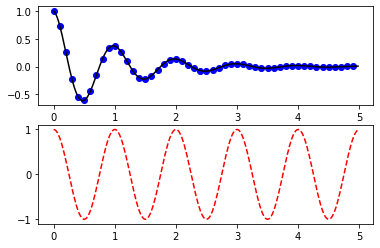

In [114]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure()
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()

/home/rdegruij/anaconda3/envs/conda_py3_tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


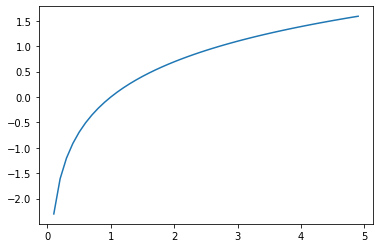

In [125]:
def f(t):
    return np.log(t)

t1 = np.arange(0.0, 5.0, 0.1)



plt.figure()
plt.plot(t1, f(t1))

plt.show()

In [259]:
p = [[0,0,0,1,0],
     [0,1,0,1,0],
     [0,1,0,1,0],
     [0,1,0,1,0],
     [0,1,0,0,0]]

In [263]:


class shortestPath():
    def __init__(self):
        self.visited = set()
        self.cost=[[10 for x in range(5)] for x in range(5)]
        
        
        
        
    def run(self, p, i, j, d):
        if (i,j) not in self.visited:
            self.visited.add((i,j))
            self.cost[i][j] = d
            if i<len(p)-1:
                if p[i+1][j] != 1:
                    self.run(p, i+1, j,d+1)
                if j<len(p[0])-1:
                    if p[i+1][j+1] != 1:
                        self.run(p, i+1, j+1,d+1)
            if j<len(p[0])-1:
                if p[i][j+1] != 1:
                    self.run(p, i, j+1,d+1)
        else:
            self.cost[i][j] = min(d,self.cost[i][j])
        

    def backtrack(self):
        for q in self.cost:
            print(q)
        path = []
        i,j=(len(self.cost)-1,len(self.cost[0])-1)
        while i>0 or j>0:
            if self.cost[i-1][j] < self.cost[i-1][j-1] and self.cost[i-1][j] < self.cost[i][j-1]:
                i=i-1
                path.append((i,j))
            elif self.cost[i-1][j-1] < self.cost[i][j-1] and self.cost[i-1][j-1] < self.cost[i-1][j]:
                i=i-1
                j=j-1
                path.append((i,j))
            else:
                j=j-1
                path.append((i,j))
        print (path)
        

In [264]:
sp = shortestPath()

In [265]:

sp.run(p, 0, 0, 0)
sp.backtrack()

[0, 1, 2, 10, 10]
[1, 10, 2, 10, 10]
[2, 10, 3, 10, 10]
[3, 10, 4, 10, 10]
[4, 10, 5, 5, 7]
[(4, 3), (3, 2), (2, 2), (1, 2), (0, 1), (0, 0)]
